# Photon convolved with a cavity transfer function

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import convolve
from numpy.fft import fftfreq, fftshift

from lmfit import Model, Parameters
from lmfit.models import ConstantModel
from lmfit.models import LorentzianModel

## Photon function definitions

In [2]:
def exponential_decay(t, tau, alpha=1e-3):
    """Electric field envelope for an exponential decay"""
    assert tau > 0
    mask = t > - (tau * 10)
    retval = np.zeros_like(t)
    retval[mask] = np.exp(-t[mask] / (2 * tau)) * (1 + np.tanh(t[mask] / alpha))/2
    return retval / np.sum(retval)

def exponential_rise(t, tau, alpha=1e-3):
    """Electric field envelope for an exponential rise"""
    assert tau < 0
    mask = t < (-tau * 10)
    retval = np.zeros_like(t)
    retval[mask] = np.exp(-t[mask] / (2 * tau)) * (1 + np.tanh(-t[mask] / alpha))/2
    return retval / np.sum(retval)

def exponential_pulse(x, tau, t0=0, amp=1, alpha=1e-3):
    """ Electric field envelope for asymetric pulses
    
    if tau is positive, there will be a decaying exponential
    if tau is negative, rising exponential"""
    x = x - t0
    if tau < 0:
        return amp * exponential_rise(x, tau, alpha)
    return amp * exponential_decay(x, tau, alpha)

# Cavity functions

In [3]:
def finesse(R1, R2):
    return np.pi * (R1 * R2)**.25 / (1 - np.sqrt(R1 * R2))

def FSR(R1, R2, cavity_lw):
    return finesse(R1, R2) * cavity_lw

def FP_cavity_transferfunction(d_freq, R1, R2, cavity_lw):
    d_freq = d_freq * (2 * np.pi)
    fsr = FSR(R1, R2, cavity_lw)
    return (np.sqrt(R1) - np.sqrt(R2) * np.exp(-1j*d_freq / fsr)) / (1 - np.sqrt(R1*R2) * np.exp(-1j*d_freq / fsr))

def cavity_reflection(pulse, dt, R1, R2, cavity_lw, cavity_detuning):
    # frequency vector to define the transfer function properly
    freq_vec = np.fft.fftfreq(pulse.size, dt)

    # cavity transfer function 
    transf_func = FP_cavity_transferfunction((freq_vec - cavity_detuning), R1, R2, cavity_lw)
    
    # cavity operation in the time domain
    a = np.fft.fftshift(np.fft.ifft(transf_func))
    return convolve(pulse, a, 'same')

## Check cavity transfer function

Free spectral range 1499.094
3.658 3.6575


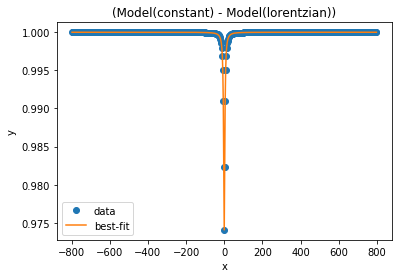

In [4]:
dt = 1e-4
time_vec = np.arange(-.2, .2, dt)
R1= 0.97
R2 = 0.9998
cavity_detuning = 100
cavity_lw = 7.315

frequencies = fftshift(fftfreq(time_vec.size, dt))
ct = FP_cavity_transferfunction(frequencies, R1, R2, cavity_lw)
# plt.figure()
# plt.plot(frequencies, np.abs(ct)**2, '.-')
print(f'Free spectral range {FSR(R1, R2, cavity_lw) :.3f}')

cavity_model = ConstantModel() - LorentzianModel()

p=Parameters()
p.add('c', 1, vary = False)
p.add('sigma', cavity_lw)
p.add('center', 0)
p.add('amplitude', .1)

useful_sec = np.abs(frequencies) < 800
result_cav = cavity_model.fit(np.abs(ct[useful_sec])**2, x = frequencies[useful_sec], params=p)
print('{:.3f}'.format(result_cav.best_values['sigma']), cavity_lw / 2)
plt.figure()
result_cav.plot_fit();

## Check of the convolution operation

In [25]:
# time vector
dt = 1e-7
time_vec = np.arange(-.1, .2, dt)

In [26]:
# photon wavefunction parameters
tau = 6e-3
alpha = 1e-7
# cavity parameters
R1= 0.97
R2 = 0.9998
cavity_detuning = 0.01
cavity_lw = 7#
print(f'photon bandwidth {1 / (2 * np.pi * (tau)) :.2f} MHz')

pulse = exponential_pulse(time_vec, tau=tau, t0=0, alpha=alpha)
pulse_after_cavity = cavity_reflection(pulse, dt, R1, R2, cavity_lw, cavity_detuning)

photon bandwidth 26.53 MHz


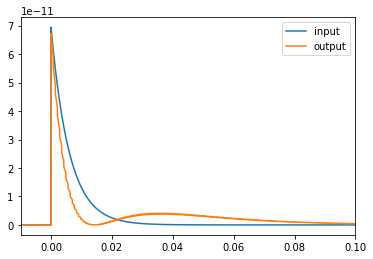

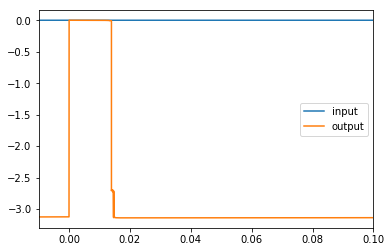

In [28]:
plt.figure()
plt.plot(time_vec, np.abs(pulse)**2, label='input')
plt.plot(time_vec, np.abs(pulse_after_cavity)**2, label='output')
plt.legend()
plt.xlim(-0.01,0.1)

plt.figure()
plt.plot(time_vec, np.angle(pulse), label='input')
plt.plot(time_vec, np.angle(pulse_after_cavity), label='output')
plt.legend();
plt.xlim(-0.01,0.1);


In [8]:
lines_to_drop = 260
exp_t, data_pulse_in, _,  _ = np.genfromtxt('pulse_before_cavity.g2', skip_header=lines_to_drop).T
_, data_pulse_out, _,  _ = np.genfromtxt('pulse_after_cavity.g2', skip_header=lines_to_drop).T

plt.figure()
plt.plot(exp_t, data_pulse_in)
plt.plot(exp_t, data_pulse_out);

OSError: pulse_before_cavity.g2 not found.

In [9]:
def exp_amplitude_f(x, tau, t0 = 0, amp = 1, alpha=1e-3):
    return exponential_pulse(x, tau, t0, amp, alpha)**2

exp_model = Model(exp_amplitude_f) + ConstantModel()

In [10]:
p = Parameters()
p.add('tau', 7e-3, min=1e-3)
p.add('alpha', 1e-2, vary=True)
p.add('amp', 1e3, min=0)
p.add('t0', .3)
p.add('c', 10)

result = exp_model.fit(data_pulse_in, p, x=exp_t / 1e3, weights=1 / np.sqrt(data_pulse_in))
print(result.fit_report())

# result.plot();

NameError: name 'data_pulse_in' is not defined

In [11]:
tau = result.best_values['tau']
alpha = result.best_values['alpha']

# time vector
dt = 1e-5
time_vec = np.arange(-1, 1, dt)

pulse = exponential_pulse(time_vec, tau, alpha)

pulse_after_cavity = cavity_reflection(pulse, dt, R1, R2, cavity_lw, 0)
print(cavity_lw)

NameError: name 'result' is not defined

In [12]:
plt.figure()
plt.plot(exp_t, data_pulse_out)
plt.plot(time_vec*1e3 + 368, 2.9e10 * np.abs(pulse_after_cavity)**2 + 35, label='output')
plt.xlim(250, 600);

NameError: name 'exp_t' is not defined

<Figure size 432x288 with 0 Axes>